In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cgc.coclustering import Coclustering

from dask_yarn import YarnCluster
from dask.distributed import Client

# Co-clustering with CGC and Dask YARN cluster

## Setup Dask cluster

In [4]:
# Create a cluster
cluster = YarnCluster(
    n_workers=4,
    worker_vcores=4,
    worker_memory="12GB",
    environment="environment.tar.gz"
)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.0.101.158:33177
distributed.scheduler - INFO -   dashboard at:                    :43875


In [5]:
# connect client
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-9370dea5-a9b3-11eb-94a0-02c17bb195f4
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.0.101.158:33177 Dashboard: /proxy/43875/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.0.101.241:44965', name: dask.worker_3, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.0.101.241:44965
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.0.101.197:41155', name: dask.worker_0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.0.101.197:41155
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.0.101.207:43633', name: dask.worker_2, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.0.101.207:43633
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.0.101.17:36419', name: dask.worker_1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting wor

## Co-clustering analysis

In [14]:
nclusters_row = 5  # time
nclusters_col = 50 # space

In [7]:
# read USA mask
mask = xr.open_rasterio(
    's3://twente-spark-emr-hello-world/test-data/usa_mask.tif', 
    chunks={'x': 1952, 'y': 973}
)
mask = mask.squeeze('band', drop=True)
mask = ~mask.isnull()
mask

<xarray.DataArray (y: 3892, x: 7808)>
dask.array<invert, shape=(3892, 7808), dtype=bool, chunksize=(973, 1952), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 49.25 49.24 49.23 49.22 ... 14.32 14.31 14.31 14.3
  * x        (x) float64 -126.3 -126.3 -126.3 -126.3 ... -56.19 -56.18 -56.17

In [8]:
# read subset of first-leaf spring-index dataset
years = range(1980, 2018)
spring_index = [
    xr.open_rasterio(
        f's3://twente-spark-emr-hello-world/test-data/'
        f'spring-index/LeafFinal_one_band/{year}.tif',
        chunks={'x': 1952, 'y': 973}
    ).squeeze('band', drop=True)
    for year in years
]
spring_index = [da.where(mask) for da in spring_index]
spring_index = xr.concat(spring_index, dim='time')

# set year as time coordinate
spring_index = spring_index.assign_coords(year=('time', years))

spring_index

,Array,Chunk
Bytes,8.60 GiB,14.49 MiB
Shape,"(38, 3892, 7808)","(1, 973, 1952)"
Count,3143 Tasks,608 Chunks
Type,float64,numpy.ndarray


In [9]:
# increase chunk size in time dimension
spring_index = spring_index.chunk({'time': 10})
spring_index

<xarray.DataArray (time: 38, y: 3892, x: 7808)>
dask.array<rechunk-merge, shape=(38, 3892, 7808), dtype=float64, chunksize=(10, 973, 1952), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 49.25 49.24 49.23 49.22 ... 14.32 14.31 14.31 14.3
  * x        (x) float64 -126.3 -126.3 -126.3 -126.3 ... -56.19 -56.18 -56.17
    year     (time) int64 dask.array<chunksize=(10,), meta=np.ndarray>
Dimensions without coordinates: time
Attributes:
    transform:         (0.008983152841195215, 0.0, -126.30312894720473, 0.0, ...
    crs:               +init=epsg:4326
    res:               (0.008983152841195215, 0.008983152841195215)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.1, Mapping Toolbox 4.4

In [10]:
spring_index = spring_index.stack(space=['x', 'y'])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=('space', location))
spring_index

<xarray.DataArray (time: 38, space: 30388736)>
dask.array<reshape, shape=(38, 30388736), dtype=float64, chunksize=(10, 1899296), chunktype=numpy.ndarray>
Coordinates:
    year      (time) int64 dask.array<chunksize=(10,), meta=np.ndarray>
  * space     (space) MultiIndex
  - x         (space) float64 -126.3 -126.3 -126.3 ... -56.17 -56.17 -56.17
  - y         (space) float64 49.25 49.24 49.23 49.22 ... 14.32 14.31 14.31 14.3
    location  (space) int64 0 1 2 3 4 ... 30388732 30388733 30388734 30388735
Dimensions without coordinates: time
Attributes:
    transform:         (0.008983152841195215, 0.0, -126.30312894720473, 0.0, ...
    crs:               +init=epsg:4326
    res:               (0.008983152841195215, 0.008983152841195215)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.1, Mapping Toolbox 4.4

In [11]:
# drop pixels that are null-valued for any of the time indices
spring_index = spring_index.dropna('space', how='any') 
spring_index

<xarray.DataArray (time: 38, space: 10112344)>
dask.array<getitem, shape=(38, 10112344), dtype=float64, chunksize=(10, 1177879), chunktype=numpy.ndarray>
Coordinates:
    year      (time) int64 dask.array<chunksize=(10,), meta=np.ndarray>
  * space     (space) MultiIndex
  - x         (space) float64 -124.7 -124.7 -124.7 ... -66.99 -66.98 -66.98
  - y         (space) float64 48.16 48.15 48.19 48.18 ... 44.82 44.83 44.82
    location  (space) int64 689005 689006 692894 ... 25695477 25699368 25699369
Dimensions without coordinates: time
Attributes:
    transform:         (0.008983152841195215, 0.0, -126.30312894720473, 0.0, ...
    crs:               +init=epsg:4326
    res:               (0.008983152841195215, 0.008983152841195215)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.1, Mapping Toolbox 4.4

In [12]:
# load data
spring_index = spring_index.persist()

In [13]:
# size of the matrix
spring_index.shape, spring_index.nbytes / 2**20,  "MB"

((38, 10112344), 2931.7403564453125, 'MB')

In [15]:
# setup co-clustering analysis
cc = Coclustering(
    spring_index.data, 
    nclusters_row=nclusters_row, 
    nclusters_col=nclusters_col,
    max_iterations=20,
    nruns=1,
)

# run! 
res = cc.run_with_dask(client=client, low_memory=True)

/home/hadoop/miniconda/lib/python3.8/site-packages/distributed/worker.py:3578: UserWarning: Large object of size 1.05 MiB detected in task graph: 
  ("('remainder-9486c7ce81f19f6b9257e6bd7647b07c', 0 ... 2, 1177870]),))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


In [16]:
# create data arrays from row/col clusters
time_clusters = xr.DataArray(res.row_clusters, dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(res.col_clusters, dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

In [17]:
spring_index = spring_index.assign_coords(
    time_clusters=time_clusters, 
    space_clusters=space_clusters
)

In [18]:
# sort dataset 
spring_index_sorted = spring_index.sortby(['time_clusters', 
                                           'space_clusters'])

/home/hadoop/miniconda/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


In [22]:
spring_index_sorted

<xarray.DataArray (time: 38, space: 10112344)>
dask.array<getitem, shape=(38, 10112344), dtype=float64, chunksize=(9, 291013), chunktype=numpy.ndarray>
Coordinates:
    year            (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
  * space           (space) MultiIndex
  - x               (space) float64 -124.5 -124.5 -124.5 ... -69.94 -69.94
  - y               (space) float64 42.85 42.85 42.86 42.85 ... 41.8 41.79 41.79
    location        (space) int64 763544 763545 767435 ... 24419238 24419239
    time_clusters   (time) int64 3 3 3 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4 4 4 4
    space_clusters  (space) int64 0 0 0 0 0 0 0 0 0 ... 48 48 48 48 48 48 48 48
Dimensions without coordinates: time
Attributes:
    transform:         (0.008983152841195215, 0.0, -126.30312894720473, 0.0, ...
    crs:               +init=epsg:4326
    res:               (0.008983152841195215, 0.008983152841195215)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.1, Mapping Toolbox 4.4

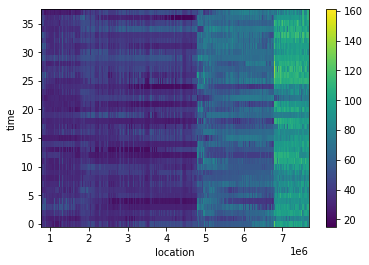

In [34]:
cutout = spring_index_sorted.isel(space=slice(0, 2_000_000))
cutout.plot.imshow(x='location', y='time')

## Shutdown Dask cluster

In [35]:
client.close()
cluster.shutdown()

distributed.scheduler - INFO - Remove client Client-9370dea5-a9b3-11eb-94a0-02c17bb195f4
distributed.scheduler - INFO - Remove client Client-9370dea5-a9b3-11eb-94a0-02c17bb195f4
distributed.scheduler - INFO - Close client connection: Client-9370dea5-a9b3-11eb-94a0-02c17bb195f4
distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.0.101.241:44965', name: dask.worker_3, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.0.101.241:44965
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.0.101.197:41155', name: dask.worker_0, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.0.101.197:41155
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.0.101.207:43633', name: dask.worker_2, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.0.101.207:43633
distributed.schedule